In [40]:
%matplotlib inline

import distributed
from dask.distributed import Client, progress
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import numpy as np
import pandas as pd
import uproot
import backports.lzma

import utils
import glob
import uproot_methods
import matplotlib.pyplot as plt

utils.bokeh_output_notebook()

Loading BokehJS ...

### useful links
* [custom use cases](https://webcache.googleusercontent.com/search?q=cache:ibMAJ_NTsgAJ:https://github.com/dask/dask/blob/master/docs/source/use-cases.rst+&cd=6&hl=en&ct=clnk&gl=us)

In [41]:
c = Client("uaf-1.t2.ucsd.edu:50123")
c

Client Scheduler: tcp://uaf-1.t2.ucsd.edu:50123 Dashboard: http://uaf-1.t2.ucsd.edu:8787/status,Cluster Workers: 10 Cores: 10 Memory: 80.00 GB


In [42]:
%%html
<iframe src="http://localhost:8787/status" width="100%" height="500px"></iframe>

In [43]:
def initialize_arraycache():
    from distributed import get_worker
    import uproot
    worker = get_worker()
    worker.cache = uproot.ArrayCache("6 GB")
c.run(initialize_arraycache);

In [44]:
# Register a custom metric for uaf-1.t2.ucsd.edu:8787 dashboard Workers tab
# for uproot ArrayCache size
# https://distributed.readthedocs.io/en/latest/web.html
def cachesize_metric():
    def f(worker):
        if hasattr(worker,"cache"):
            return "{:.2f}GB".format(worker.cache._cache.currsize/1e9)
        return 0
    return f

def register_metrics(dask_worker):
    dask_worker.metrics["cachesize"] = cachesize_metric()

c.run(register_metrics);

In [45]:
%%time
futures = c.map(lambda x:x, range(100),pure=False)
np.array(c.gather(futures)).shape

CPU times: user 33 ms, sys: 1 ms, total: 34 ms
Wall time: 139 ms


(100,)

In [46]:
fnames = sorted(glob.glob("/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run*/*.root"))[:10]
chunks, total_nevents = utils.get_chunking(tuple(fnames),int(1.0e6))
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

24 chunks of 10 files, with a total of 1.8467e+07 events


In [47]:
%%time
def get_hist(args):
    fname,entrystart,entrystop = args
    f = uproot.open(fname)
    t = f["Events"]
    try:
        from distributed import get_worker
        cache = get_worker().cache
    except:
        cache = None
    extra = dict(outputtype=tuple,namedecode="ascii",entrystart=entrystart,entrystop=entrystop,cache=cache)
    mus = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        *t.arrays(["Muon_pt","Muon_eta","Muon_phi","Muon_mass"],**extra)
    )
    mus = mus[mus.counts==2]
    mll = (mus[:,0]+mus[:,1]).mass
    bins = np.logspace(np.log10(0.5),np.log10(1000),num=300)
    counts,_ = np.histogram(np.clip(mll,bins[0],bins[-1]),bins=bins)
    return counts

x = get_hist((chunks[0][0],chunks[0][1],chunks[0][2]//20))
x.sum()

CPU times: user 850 ms, sys: 52 ms, total: 902 ms
Wall time: 1.05 s


5489

In [48]:
%%time
futures = c.map(get_hist,chunks,pure=False)
results = c.gather(futures)
len(results)

CPU times: user 356 ms, sys: 43 ms, total: 399 ms
Wall time: 1min 35s


24

In [49]:
d = c.who_has(futures)
workers = [set(d[f.key]) for f in futures]

In [50]:
futures = c.map(get_hist,chunks,workers=workers,pure=False)

In [51]:
progress(futures)

VBox()

In [52]:
results = c.gather(futures)

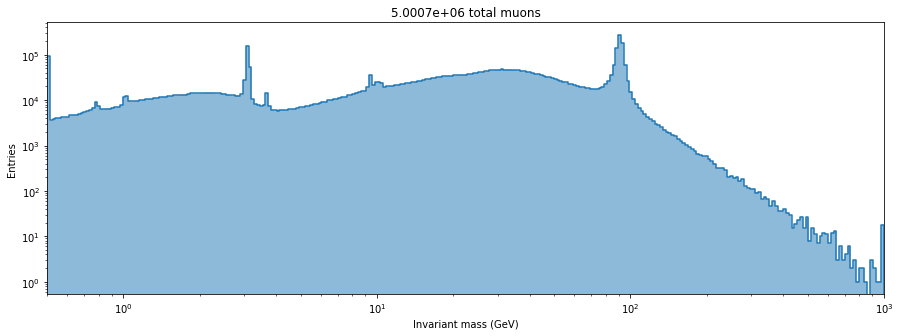

In [53]:
bins = np.logspace(np.log10(0.5),np.log10(1000),num=300)
counts = sum(results)

fig,ax = plt.subplots(figsize=(15,5))
ax.step(x=bins, y=np.append(counts,0), where="post")
ax.fill_between(x=bins, y1=np.append(counts,0), step="post",alpha=0.5)
ax.set_xlim(bins[0],bins[-1])
# ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel("Invariant mass (GeV)")
ax.set_title("{:.5g} total muons".format(counts.sum()))
ax.set_ylabel("Entries");
ax.set_xscale("log")
ax.set_yscale("log")

In [54]:
utils.plot_timeflow(c.get_task_stream(count=len(futures)))

In [55]:
if False:
    # kill all but 10
    workers_tokill = list(c.scheduler_info()["workers"].keys())[10:]
    c.retire_workers(workers=workers_tokill,remote=True)